In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

In [5]:
#enter constants
f_mode1 = 4.993017E6
f_mode2 = 5.505658500E+6 #- 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01
fs=100

w_mode1= 2*np.pi*f_mode1
w_mode2= 2*np.pi*f_mode2
tau1=Q1/w_mode1
tau2=Q2/w_mode2

h0=0.0005
trap=0.848

Zsquid= 1.2e6

In [6]:
data1=data[:10000000]

In [7]:
print(len(data))

24089000


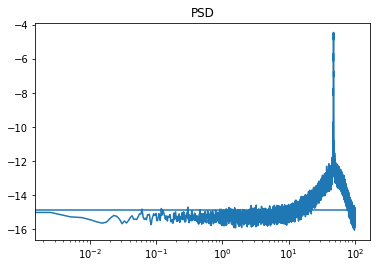

In [8]:
#PSD using Welch method 
f_1, S_1 = welch(
        (data1)-np.mean(data1), fs=fs, nperseg=(len(data1)/256),
         return_onesided=False, detrend=None, scaling='density', window='hanning')

#to plot log log have shifted frequency axis to positive 
plt.plot(f_1+abs(np.min(f_1)), 10*np.log10(S_1))
plt.title('PSD')
plt.xscale('log')


In [9]:
#SPECTRAL DISPLACEMENT DENSITY Su
#eq (8) GW Summary

#omega frequency axis, add mode freq 1 and convert from Hz to rad/s, and create squared axis 
w_1= [(x+f_mode1)*(2*np.pi) for x in f_1]
w_1sq= [x**2 for x in w_1]

#multiply 1/omega^2 list and Sv 
product1= [(1/a) * b for a, b in zip(w_1sq, S_1)]
 
#put into equation for Su(omega)
#10^-6 squared is a conversion from micro V to V
constants1 = (1/kappa_1**2)*(1/(Zsquid**2)*(10**(-6))**2)
Su1 = [x*(constants1) for x in product1]

Text(0.5, 1.0, 'Spectral Displacement Density')

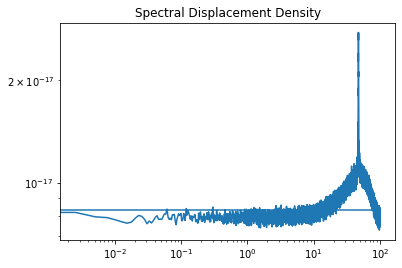

In [10]:
plt.plot(f_1+abs(np.min(f_1)), np.sqrt(Su1))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectral Displacement Density')

In [11]:
#transfer function (equation 6 GW Summary)
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+w_mode1**2))

In [12]:
H_1=np.array(list(map(trans1,2*np.pi*(f_1+f_mode1))))

Text(0.5, 1.0, 'Transfer Function')

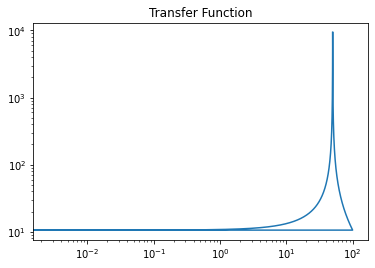

In [13]:
plt.plot(f_1+abs(np.min(f_1)), H_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Transfer Function')

Text(0.5, 1.0, 'Strain Sensitivity ')

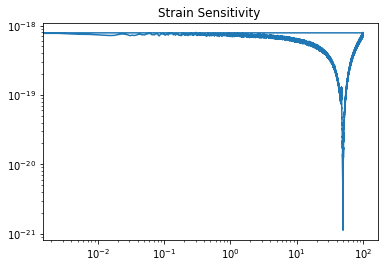

In [14]:
h_1=np.sqrt(Su1)/H_1

plt.plot(f_1+abs(np.min(f_1)), h_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Strain Sensitivity ')

In [15]:
#convert Su back to complex time series 
#psd= np.sqrt(Su1)
Su1i=np.fft.ifft(np.sqrt(Su1))
print(Su1i[:10])

[9.32643030e-18-2.21110487e-35j 7.97509365e-19-2.42114962e-20j
 1.65536730e-19-4.90393567e-20j 1.41131683e-19-7.28325971e-20j
 1.24751818e-19-8.93119340e-20j 1.11686640e-19-1.04711944e-19j
 8.98550082e-20-1.14201619e-19j 6.59522747e-20-1.25391342e-19j
 4.34246088e-20-1.31063251e-19j 2.45187356e-20-1.32539563e-19j]


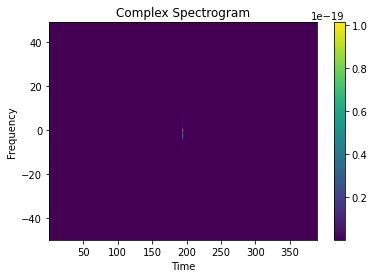

In [16]:
#complex data spectrogram
f, t, Sxx = signal.spectrogram(Su1i-np.mean(Su1i), 100, nperseg=100, return_onesided=False, mode='complex')
plt.pcolormesh(t, fftshift(f), fftshift(abs(Sxx)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Complex Spectrogram')
plt.show()

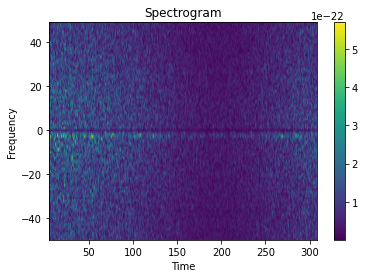

In [17]:
#extract section without power spike 
SxxA=np.array(Sxx)
SxxC= SxxA[0:100,4:350]

difft=np.delete(t[4:351],0)

plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectrogram')
plt.show()

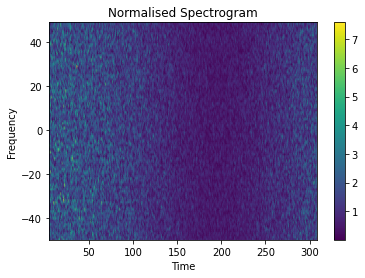

In [18]:
#FIND THRESHOLD NOISE AMPLITUDE AT FREQUENCY AWAY FROM RESONANT MODE 

#normalise data spectrogram 
absnormSxxD=[]

for i in range(0,len(SxxC)):
    absnormSxxD.append(abs((SxxC[i]/np.median(abs(SxxC[i])))))
    
plt.pcolormesh(difft, fftshift(f), fftshift(absnormSxxD, axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Normalised Spectrogram')
plt.show()

In [19]:
#first amplitude value
print(abs(SxxC[0][0]))

#median of first frequency row
print(np.median(abs(SxxC[0])))

#resulting array element and manual calc match, OOMs makes sense
print(absnormSxxD[0][0])
print(abs(SxxC[0][0]/np.median(abs(SxxC[0]))))

6.313482404059496e-23
2.700792637703064e-23
2.337640556303096
2.337640556303096


In [20]:
#mean reduces amplitudes slightly but this is because transient skews the mean to be larger
#also still in -26,-25 range to get curve

#print(absnormSxxD[0][0])
#print(abs(SxxC[0][0]))
#print(np.mean(abs(SxxC[0])))
#print(abs(SxxC[0][0]/np.mean(abs(SxxC[0]))))

In [21]:
#differencing for data spectrogram (D for data)

timecolsD=np.transpose(absnormSxxD)

absdiffD=[]
slice1=[]

for j in range(0,len(absnormSxxD)):
    slice1.clear()
    for i in range(0,(len(absnormSxxD[0])-1)):
        slice1.append(abs(timecolsD[i+1][j]-timecolsD[i][j]))
    absdiffD.append(slice1[:])
    
#print(len(absdiffD))
#print(len(absdiffD[0]))

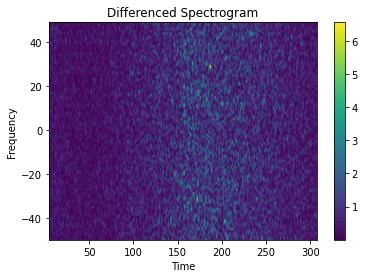

In [22]:
difftD=np.delete(t[4:350],0)

plt.pcolormesh(difftD, fftshift(f), np.array(fftshift(absdiffD)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced Spectrogram')
plt.show()

In [23]:
#differencing doesn't increase amplitudes or seem to be causing problem
print(np.max(absnormSxxD))
print(np.max(absdiffD))

7.585499602830575
6.5564530482102565


In [24]:
#select area away from res mode and find max amplitude (around 20-40Hz)

#this corresponds to frequency index approx 21-41
#print(np.shape(absdiffD))
#print(f)
absdiffDA=np.array(absdiffD)

noiserows=absdiffDA[21:41,:].copy()
print(np.shape(noiserows))

threshold=np.amax(noiserows)
print(threshold)

(20, 345)
6.5564530482102565


In [25]:
#create loop which essentially completes transient difference stest for 100 delta functions 
#at each of a range of h amplitudes to count if they are above threshold 

In [26]:
#(range and arange don't work well with non integer values)
h=np.linspace(1e-23,1e-22,10)
#print(len(h))
#print(h)

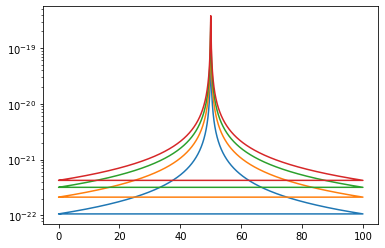

In [27]:
#SIM SIGNAL CHECK
#simulated signal- same loop just not resampled so I can plot 
Su_simUS=[]
slice2US=[]

for i in range(0,len(h)):
    slice2US.clear()
    for j in range(0,len(H_1)):
        slice2US.append((h[i]*abs(H_1[j])))
    Su_simUS.append(slice2US[:])

plt.plot(f_1+abs(np.min(f_1)), Su_simUS[0])
plt.plot(f_1+abs(np.min(f_1)), Su_simUS[1])
plt.plot(f_1+abs(np.min(f_1)), Su_simUS[2])
plt.plot(f_1+abs(np.min(f_1)), Su_simUS[3])
#plt.xscale('log')
plt.yscale('log')
#plt.title('Transient Sim Spectral Displacement Density')

#transient shape before resampling looks to be correct

In [28]:
#print(np.argmax(Su_sim[0]))

In [29]:
#create simulated transient for each h amplitude and resample to match dimension of spec to add
Su_sim=[]
slice2=[]

for i in range(0,len(h)):
    slice2.clear()
    for j in range(0,len(H_1)):
        slice2.append((h[i]*abs(H_1[j])))
    Su_sim.append(signal.resample(slice2[:],len(f)))
    #Su_sim.append(slice2[:])
        
print(np.shape(Su_sim))
#print(len(Su_sim))
#print(len(Su_sim[0]))
#print(Su_sim)

#plt.plot(f_1[:100]+abs(np.min(f_1)), Su_sim[0])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[1])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[2])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[3])
#plt.xscale('log')
#plt.yscale('log')

#problem with resampling ?

(10, 100)


In [30]:
#trying to 'manually' resample - makes problem worse 
print(len(Su_simUS[0]))
Su_simUS0=Su_simUS[0]
#samplesize
ss=len(Su_simUS[0])/len(f)
print(ss)

Su_simS0=Su_simUS0[0::int(ss)]
print(len(Su_simS0))

Su_simS0f=Su_simS0[:100]
print(len(Su_simS0f))

#plt.plot(f_1[:101]+abs(np.min(f_1)), Su_simS0)
#plt.yscale('log')

39062
390.62
101
100


In [31]:
import random

In [32]:
count=0

#for x in range(0,100):
randomcol=random.randint(0,(len(SxxC[0])-1))
    #print(randomcol)
SxxC[:,50]= [a+b for a,b in zip(SxxC[:,50],Su_sim[0])]
    
absnormSxxsim=[]

for k in range(0,len(SxxC)):
    absnormSxxsim.append(abs((SxxC[k]/np.median(abs(SxxC[k])))))

#NORM CHECK
#amplitude value
print(abs(SxxC[10][10]))
#median of frequency row
print(np.median(abs(SxxC[10])))
#resulting array element and manual calc match, OOMs okay
print(absnormSxxsim[10][10])
print(abs(SxxC[10][10]/np.median(abs(SxxC[10]))))
    
    
timecols=np.transpose(absnormSxxsim)
absdiff=[]
slice3=[]

for j in range(0,len(absnormSxxsim)):
    slice3.clear()
    for i in range(0,(len(absnormSxxsim[0])-1)):
        slice3.append(abs(timecols[i+1][j]-timecols[i][j]))
    absdiff.append(slice3[:])
    
    #print(absdiff[0][0])
    
maxamp=np.amax(absdiff)
    #print(maxamp)
    
if maxamp > threshold:
    count+=1
    
#SxxC[:,50]= [a-b for a,b in zip(SxxC[:,50],Su_sim[9])]
#this is where transient is removed each time to prevent them being normalised out 

print(count)
    
    
   

3.443138490767766e-22
7.29058025316983e-23
4.722722158185892
4.722722158185892
1


In [33]:
print(maxamp)
print(randomcol)

1123.9675449941026
209


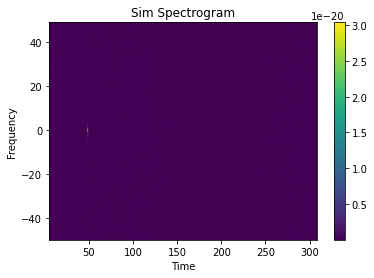

In [34]:
plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Sim Spectrogram')
plt.show()

#correct as transient from [30] has been removed 

In [35]:
print(np.argmax(SxxC))

50


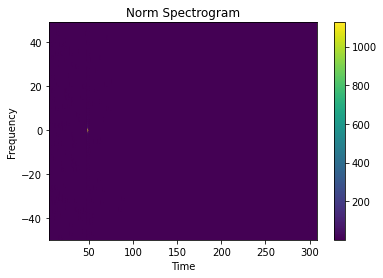

In [36]:
plt.pcolormesh(difft, fftshift(f), fftshift((absnormSxxsim), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Norm Spectrogram')
plt.show()


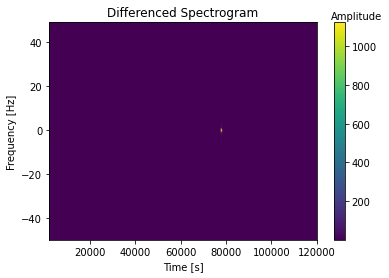

In [37]:
plt.pcolormesh(difftD*(len(Su1i)/100), fftshift(f), np.array(fftshift(absdiff)), shading='gouraud')
#plt.colorbar()
plt.colorbar().set_label('Amplitude',labelpad=-20, y=1.05, rotation=0)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Differenced Spectrogram')
plt.show()

#fine as absdiff should show transient and much higher amplitude than differenced spectrum without

In [38]:
np.shape(absdiff)
#np.shape(absnormSxxsim)

(100, 345)

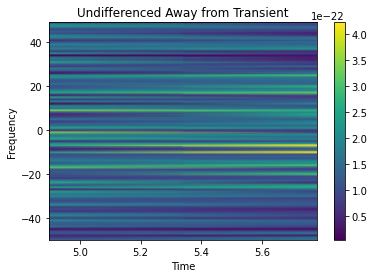

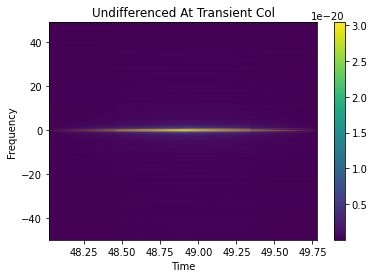

In [39]:
#NORMALISATION CHECK 

#UNDIFFERENCED

#AWAY FROM TRANSIENT
plt.pcolormesh(difft[:2], fftshift(f), fftshift(abs(SxxC[0:100,0:2]), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Undifferenced Away from Transient')
plt.show()

#TRANSIENT
plt.pcolormesh(difft[49:52], fftshift(f), fftshift(abs(SxxC[0:100,49:52]), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Undifferenced At Transient Col')
plt.show()

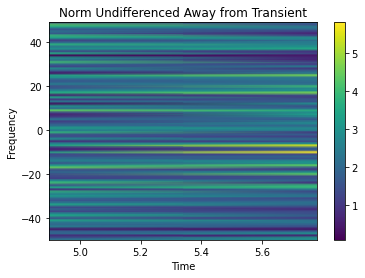

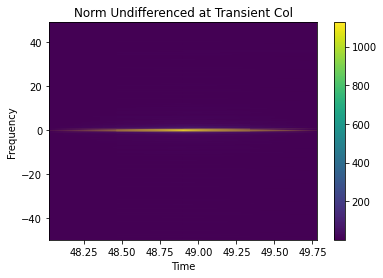

In [40]:
#NORMED UNDIFFERENCED 

absnormSxxsimA=np.array(absnormSxxsim)

#AWAY FROM TRANSIENT
plt.pcolormesh(difft[:2], fftshift(f), fftshift(absnormSxxsimA[0:100,0:2], axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Norm Undifferenced Away from Transient')
plt.show()

#AT TRANSIENT
plt.pcolormesh(difft[49:52], fftshift(f), fftshift(absnormSxxsimA[0:100,49:52], axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Norm Undifferenced at Transient Col')
plt.show()

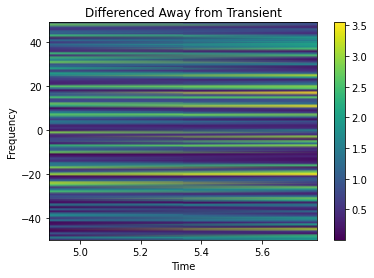

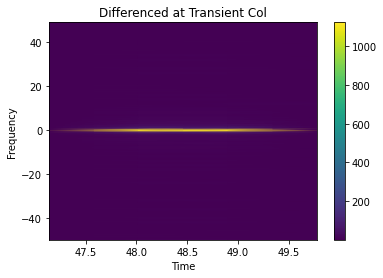

In [41]:
#DIFFERENCED

absdiffAsim= np.array(absdiff)

#AWAY
plt.pcolormesh(difftD[:2], fftshift(f), fftshift(absdiffAsim[0:100,0:2], axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced Away from Transient')
plt.show()

#TRANSIENT
plt.pcolormesh(difft[48:52], fftshift(f), fftshift(absdiffAsim[0:100,48:52], axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced at Transient Col')
plt.show()

In [42]:
#peakSusim=[]


#for i in range(0,len(Su_simUS)):
#    peakSusim.append(np.amax(Su_simUS[i]))
    
#print(peakSusim)

In [43]:
#SNR calcs

noiseund=absnormSxxsimA[21:41,:].copy()
SNRund=(np.amax(absnormSxxsimA)/np.amax(noiseund))
print(SNRund)

noisediff=absdiffAsim[21:41,:].copy()
SNRd=(np.amax(absdiffAsim)/np.amax(noisediff))
print(SNRd)

133.17857925103888
140.84322993110248


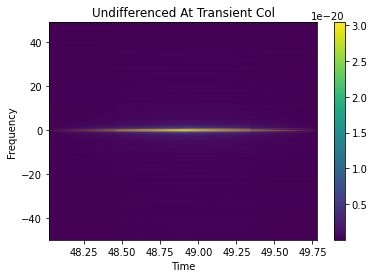

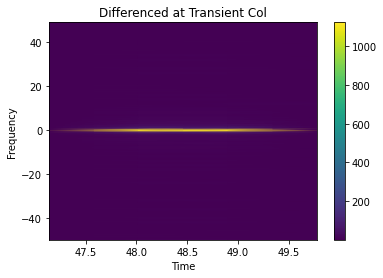

In [44]:
#transient comparison

plt.pcolormesh(difft[49:52], fftshift(f), fftshift(abs(SxxC[0:100,49:52]), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Undifferenced At Transient Col')
plt.show()

plt.pcolormesh(difft[48:52], fftshift(f), fftshift(absdiffAsim[0:100,48:52], axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced at Transient Col')
plt.show()

In [45]:
#histograms for data spectrogram distro (no transient added)

first10diff=absdiffDA[0:10,:].copy()
last10diff=absdiffDA[90:100,:].copy()

peakdiff=np.concatenate((last10diff, first10diff), axis=0)

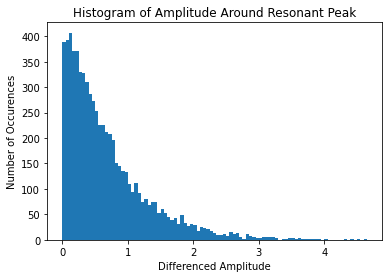

In [46]:
binwidth=0.05
binspeak= np.arange(0, np.amax(peakdiff)+binwidth, binwidth)

plt.hist(peakdiff.flatten(), binspeak)
plt.title('Histogram of Amplitude Around Resonant Peak')
plt.xlabel('Differenced Amplitude')
plt.ylabel('Number of Occurences')
#plt.xlim(0,3)
#plt.ylim(0,80)
plt.show()

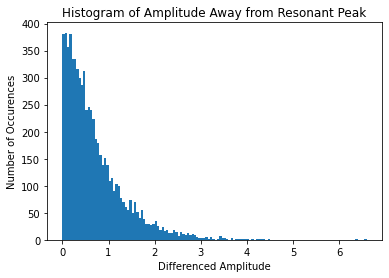

In [47]:
binwidth=0.05
binsaway= np.arange(0, np.amax(noiserows)+binwidth, binwidth)

plt.hist(noiserows.flatten(), binsaway)
plt.title('Histogram of Amplitude Away from Resonant Peak')
plt.xlabel('Differenced Amplitude')
plt.ylabel('Number of Occurences')
#plt.xlim(0,3)
#plt.ylim(0,80)
plt.show()

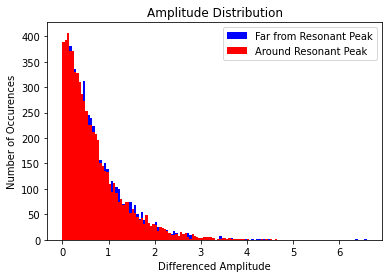

In [48]:
#Histograms plotted together  

plt.hist(noiserows.flatten(), binsaway, color='b', label='Far from Resonant Peak')
plt.hist(peakdiff.flatten(), binspeak, color='r', label='Around Resonant Peak')
plt.legend(loc='upper right')
plt.title('Amplitude Distribution')
plt.xlabel('Differenced Amplitude')
plt.ylabel('Number of Occurences')
plt.show()